# Create a cross-walk for diff geographies of LA

## Using Neighborhoods, District, Census Blocks, Census Tracts in this notebook

In [1]:
%pylab inline
import pandas as pd
import numpy as np

import geopandas as gpd
from fiona.crs import from_epsg
from geopandas.tools import sjoin, overlay

import pylab as pl
import os

Populating the interactive namespace from numpy and matplotlib


### Function for overlay

In [2]:
def spatial_overlays(df1, df2, how='intersection', reproject=True):
    """Perform spatial overlay between two polygons.

    Currently only supports data GeoDataFrames with polygons.
    Implements several methods that are all effectively subsets of
    the union.

    Parameters
    ----------
    df1 : GeoDataFrame with MultiPolygon or Polygon geometry column
    df2 : GeoDataFrame with MultiPolygon or Polygon geometry column
    how : string
        Method of spatial overlay: 'intersection', 'union',
        'identity', 'symmetric_difference' or 'difference'.
    use_sindex : boolean, default True
        Use the spatial index to speed up operation if available.

    Returns
    -------
    df : GeoDataFrame
        GeoDataFrame with new set of polygons and attributes
        resulting from the overlay

    """
    from functools import reduce
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    if df1.crs!=df2.crs and reproject:
        print('Data has different projections.')
        print('Converted data to projection of first GeoPandas DatFrame')
        df2.to_crs(crs=df1.crs, inplace=True)
    if how=='intersection':
        # Spatial Index to create intersections
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        pairs = df1['sidx'].to_dict()
        nei = []
        for i,j in pairs.items():
            for k in j:
                nei.append([i,k])
        pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
        pairs = pairs.merge(df1, left_on='idx1', right_index=True)
        pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
        pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
        pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
        cols = pairs.columns.tolist()
        cols.remove('geometry_1')
        cols.remove('geometry_2')
        cols.remove('sidx')
        cols.remove('bbox')
        cols.remove('Intersection')
        dfinter = pairs[cols+['Intersection']].copy()
        dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
        dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
        dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
        dfinter.drop(['idx1','idx2'], inplace=True, axis=1)
        return dfinter
    elif how=='difference':
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        df1['new_g'] = df1.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                                 [x.geometry]+list(df2.iloc[x.sidx].geometry)) , axis=1)
        df1.geometry = df1.new_g
        df1 = df1.loc[df1.geometry.is_empty==False].copy()
        df1.drop(['bbox', 'sidx', 'new_g'], axis=1, inplace=True)
        return df1
    elif how=='symmetric_difference':
        df1['idx1'] = df1.index.tolist()
        df2['idx2'] = df2.index.tolist()
        df1['idx2'] = np.nan
        df2['idx1'] = np.nan
        dfsym = df1.merge(df2, on=['idx1','idx2'], how='outer', suffixes=['_1','_2'])
        dfsym['geometry'] = dfsym.geometry_1
        dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry'] = dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry_2']
        dfsym.drop(['geometry_1', 'geometry_2'], axis=1, inplace=True)
        dfsym = gpd.GeoDataFrame(dfsym, columns=dfsym.columns, crs=df1.crs)
        spatial_index = dfsym.sindex
        dfsym['bbox'] = dfsym.geometry.apply(lambda x: x.bounds)
        dfsym['sidx'] = dfsym.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        dfsym['idx'] = dfsym.index.values
        dfsym.apply(lambda x: x.sidx.remove(x.idx), axis=1)
        dfsym['new_g'] = dfsym.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                         [x.geometry]+list(dfsym.iloc[x.sidx].geometry)) , axis=1)
        dfsym.geometry = dfsym.new_g
        dfsym = dfsym.loc[dfsym.geometry.is_empty==False].copy()
        dfsym.drop(['bbox', 'sidx', 'idx', 'idx1','idx2', 'new_g'], axis=1, inplace=True)
        return dfsym
    elif how=='union':
        dfinter = spatial_overlays(df1, df2, how='intersection')
        dfsym = spatial_overlays(df1, df2, how='symmetric_difference')
        dfunion = dfinter.append(dfsym)
        dfunion.reset_index(inplace=True, drop=True)
        return dfunion
    elif how=='identity':
        dfunion = spatial_overlays(df1, df2, how='union')
        cols1 = df1.columns.tolist()
        cols2 = df2.columns.tolist()
        cols1.remove('geometry')
        cols2.remove('geometry')
        cols2 = set(cols2).intersection(set(cols1))
        cols1 = list(set(cols1).difference(set(cols2)))
        cols2 = [col+'_1' for col in cols2]
        dfunion = dfunion[(dfunion[cols1+cols2].isnull()==False).values]
        return dfunion

### Reading county districts

In [ ]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/2011/12/DPW-Supervisorial-District.zip

In [ ]:
#!unzip DPW-Supervisorial-District.zip

In [3]:
dis = gpd.GeoDataFrame.from_file('sup_dist_2011.shp')

In [4]:
dis.head()

,OBJECTID,SUP_DIST_N,SYMBOL,PERIMETER,AREA_SQ_MI,SHAPE_AREA,SHAPE_LEN,geometry
0,1601,1,0,0.0,246.202,6.863264e+09,9.468181e+05,"POLYGON ((6475522.520815164 1854039.384190947,..."
1,1602,2,0,0.0,161.825,4.511450e+09,4.770922e+05,"POLYGON ((6468907.000064343 1855564.500267982,..."
2,1603,3,0,0.0,431.197,1.202126e+10,7.599277e+05,"POLYGON ((6408702.37511982 1944349.975085139, ..."
3,1604,4,0,0.0,439.931,1.226499e+10,2.076227e+06,(POLYGON ((6626754.675794035 1834251.849502847...
4,1605,5,0,0.0,2807.022,7.825435e+10,1.671393e+06,"POLYGON ((6408702.37511982 1944349.975085139, ..."


### Reading county Census Blocks

In [ ]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/ShapefilePackages/CENSUS_BLOCKS_2010.zip

In [ ]:
#!unzip CENSUS_BLOCKS_2010.zip

In [5]:
block = gpd.GeoDataFrame.from_file('CENSUS_BLOCKS_2010.shp')

### Reading county Census Tracts

In [ ]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/ShapefilePackages/CENSUS_TRACTS_2010.zip

In [ ]:
#!unzip CENSUS_TRACTS_2010.zip

In [6]:
tract = gpd.GeoDataFrame.from_file('CENSUS_TRACTS_2010.shp')

In [7]:
tract.head()

,GEOID10,CT10,LABEL,X_Center,Y_Center,Shape_STAr,Shape_STLe,geometry
0,06037911001,911001,9110.01,6620403.0,1998891.0,4.025736e+09,353933.808192,"POLYGON ((6661890.013041019 2025618.300745264,..."
1,06037980003,980003,9800.03,6575300.0,2112006.0,2.078690e+09,273188.863210,"POLYGON ((6597523.249386355 2100300.408598602,..."
2,06037930301,930301,9303.01,6603027.0,1932124.0,1.111802e+10,628603.531323,"POLYGON ((6665669.120312199 1967117.056199431,..."
3,06037573003,573003,5730.03,6500215.0,1747305.0,4.824002e+06,9050.008458,"POLYGON ((6501132.578979105 1748610.391507596,..."
4,06037297602,297602,2976.02,6473372.0,1719119.0,6.697031e+06,12308.315385,"POLYGON ((6474090.419808939 1721548.559804603,..."


### CDC Block Data (Not a good geography)

In [8]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/ShapefilePackages/CDC_PROJECT_AREAS.zip

In [9]:
#!unzip CDC_PROJECT_AREAS.zip

In [10]:
cdc = gpd.GeoDataFrame.from_file('CDC_PROJECT_AREAS.shp')

In [11]:
cdc.head()

,Program,Division,Type,Active,Label,Shape_STAr,Shape_STLe,geometry
0,Willowbrook Community Community Business Revit...,EHD,community business revitalization program,1,Willowbrook CRPA,1.578942e+07,17490.190856,"POLYGON ((6489481.909039021 1796748.493722022,..."
1,Maravilla Community Business Revitalization Area,EHD,community business revitalization program,1,Maravilla CBRA,9.146995e+06,13347.617242,"POLYGON ((6510313.59276928 1838511.895103186, ..."
2,East Rancho Dominguez Community Business Revit...,EHD,community business revitalization program,1,East Rancho Dominguez CBRA,2.375246e+06,12758.329334,"POLYGON ((6501484.179653853 1784431.447490022,..."
3,Whiteside Community Business Revitalization Area,EHD,community business revitalization program,1,Whiteside CBRA,7.455587e+06,15640.483678,"POLYGON ((6507752.102157354 1845100.172280937,..."
4,City Terrace Community Business Revitalization...,EHD,community business revitalization program,1,City Terrace CBRA,7.955454e+05,6906.353498,"POLYGON ((6509074.500103116 1843176.999946192,..."


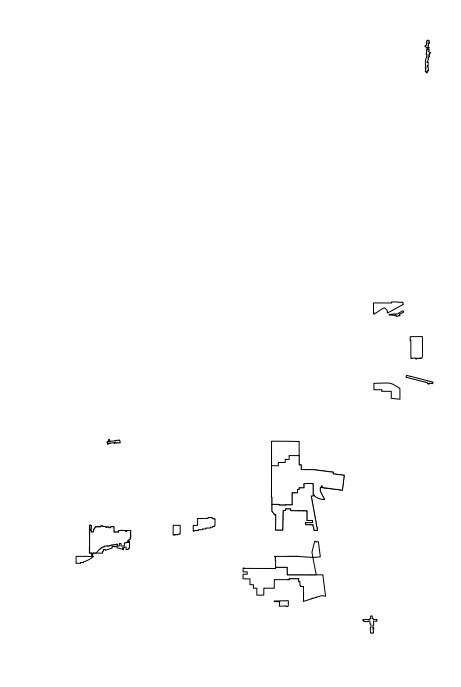

In [12]:
ax = cdc.plot(color='w', edgecolor='k', figsize=(12,12))
ax.axis('off');

## Neighborhood Tabulation

In [13]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/2015/09/LACITY_NEIGHBORHOOD_COUNCILS.zip

In [14]:
#!unzip LACITY_NEIGHBORHOOD_COUNCILS.zip

In [15]:
nbd = gpd.GeoDataFrame.from_file('LACITY_NEIGHBORHOOD_COUNCILS.shp')

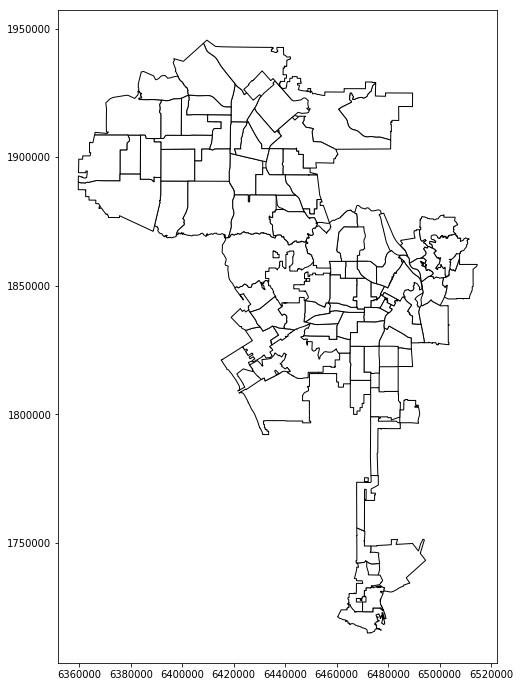

In [16]:
nbd.plot(color='w', edgecolor='k', figsize=(12,12))

## Merging Neighborhoods and Districts

In [17]:
nbd = nbd.to_crs(epsg=4326)
dis = dis.to_crs(epsg=4326)

In [18]:
nbd.head()

,NAME,WADDRESS,DWEBSITE,NC_ID,CERTIFIED,Service_Re,Shape_STAr,Shape_STLe,geometry
0,LINCOLN HEIGHTS NC,http://www.lincolnheightsnc.org/,http://empowerla.org/LHNC,47.0,2002-04-27,REGION 8 - NORTH EAST LA,8.848697e+07,45876.569373,POLYGON ((-118.2050253948447 34.05558371591044...
1,VOICES OF 90037,,http://empowerla.org/VOICESOF90037,109.0,2008-06-16,REGION 9 - SOUTH LA 2,6.079795e+07,32704.726973,POLYGON ((-118.2827327976388 34.01114282562105...
2,LOS FELIZ NC,http://www.losfeliznc.org/,http://empowerla.org/LFNC,36.0,2002-06-11,REGION 7 - EAST,2.550440e+08,103906.812029,POLYGON ((-118.3002741460729 34.15792874500053...
3,MISSION HILLS NC,http://mhnconline.org/,http://empowerla.org/MHNC,101.0,2005-04-19,REGION 1 - NORTH EAST VALLEY,1.002561e+08,49077.059544,POLYGON ((-118.4693325084467 34.28049768641279...
4,GREATER TOLUCA LAKE NC,http://www.gtlnc.org/,http://empowerla.org/GTLNC,28.0,2002-09-10,REGION 4 - SOUTH EAST VALLEY,4.187287e+07,40498.190920,POLYGON ((-118.3551995794437 34.16490994801209...


In [19]:
#nbd_dis = spatial_overlays(nbd, district_tract, how = 'union')
nbd_dis = overlay(nbd, dis, how = 'intersection')

In [20]:
nbd_dis.head()

,NAME,WADDRESS,DWEBSITE,NC_ID,CERTIFIED,Service_Re,Shape_STAr,Shape_STLe,OBJECTID,SUP_DIST_N,SYMBOL,PERIMETER,AREA_SQ_MI,SHAPE_AREA,SHAPE_LEN,geometry
0,HARBOR CITY NC,http://www.harborcitync.com/index.html,http://empowerla.org/HARBORCITYNC,92.0,2002-03-26,REGION 12 - HARBOR,6.819605e+07,46213.253488,1604,4,0,0.0,439.931,1.226499e+10,2.076227e+06,POLYGON ((-118.3089038894932 33.81702924903316...
1,HARBOR GATEWAY SOUTH NC,http://www.harborgatewaysouth.org/,http://empowerla.org/HGSNC,91.0,2003-04-08,REGION 12 - HARBOR,8.982281e+07,75888.694134,1604,4,0,0.0,439.931,1.226499e+10,2.076227e+06,POLYGON ((-118.3088084621712 33.81699577571827...
2,HARBOR GATEWAY SOUTH NC,http://www.harborgatewaysouth.org/,http://empowerla.org/HGSNC,91.0,2003-04-08,REGION 12 - HARBOR,8.982281e+07,75888.694134,1602,2,0,0.0,161.825,4.511450e+09,4.770922e+05,POLYGON ((-118.2821074918005 33.87286233163528...
3,HARBOR GATEWAY NORTH NC,http://www.harborgatewaynorth.org/,http://empowerla.org/HGNNC,90.0,2002-11-12,REGION 12 - HARBOR,8.838147e+07,69590.460835,1602,2,0,0.0,161.825,4.511450e+09,4.770922e+05,POLYGON ((-118.2818926400825 33.87285931928711...
4,HARBOR GATEWAY SOUTH NC,http://www.harborgatewaysouth.org/,http://empowerla.org/HGSNC,91.0,2003-04-08,REGION 12 - HARBOR,8.982281e+07,75888.694134,1602,2,0,0.0,161.825,4.511450e+09,4.770922e+05,POLYGON ((-118.2818926400825 33.87285931928711...


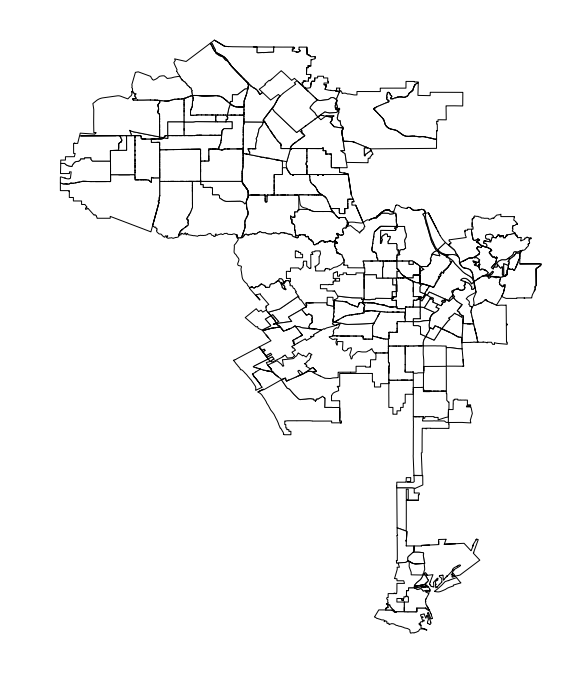

In [21]:
ax = nbd_dis.plot(color='w', edgecolor='k', figsize=(12,12))
ax.axis('off');

## Above results with Census Tracts

In [24]:
tract = tract.to_crs(epsg=4326)

In [25]:
nbd_dis.crs = {'init': 'epsg:4326', 'no_defs': True}

In [28]:
nbd_tract= spatial_overlays(nbd_dis, tract)

In [29]:
nbd_tract.head()

,NAME,WADDRESS,DWEBSITE,NC_ID,CERTIFIED,Service_Re,Shape_STAr_1,Shape_STLe_1,OBJECTID,SUP_DIST_N,...,SHAPE_AREA,SHAPE_LEN,GEOID10,CT10,LABEL,X_Center,Y_Center,Shape_STAr_2,Shape_STLe_2,geometry
0,HARBOR CITY NC,http://www.harborcitync.com/index.html,http://empowerla.org/HARBORCITYNC,92.0,2002-03-26,REGION 12 - HARBOR,6.819605e+07,46213.253488,1604,4,...,1.226499e+10,2.076227e+06,06037293301,293301,2933.01,6469368.0,1753805.0,9.096308e+06,14291.049710,POLYGON ((-118.3089038894932 33.81702924903316...
4,HARBOR GATEWAY SOUTH NC,http://www.harborgatewaysouth.org/,http://empowerla.org/HGSNC,91.0,2003-04-08,REGION 12 - HARBOR,8.982281e+07,75888.694134,1604,4,...,1.226499e+10,2.076227e+06,06037293301,293301,2933.01,6469368.0,1753805.0,9.096308e+06,14291.049710,(POLYGON ((-118.3088084621712 33.8169957757182...
89,HARBOR CITY NC,http://www.harborcitync.com/index.html,http://empowerla.org/HARBORCITYNC,92.0,2002-03-26,REGION 12 - HARBOR,6.819605e+07,46213.253488,1604,4,...,1.226499e+10,2.076227e+06,06037293301,293301,2933.01,6469368.0,1753805.0,9.096308e+06,14291.049710,POLYGON ((-118.3089038894932 33.81702924903316...
132,HARBOR CITY NC,http://www.harborcitync.com/index.html,http://empowerla.org/HARBORCITYNC,92.0,2002-03-26,REGION 12 - HARBOR,6.819605e+07,46213.253488,1602,2,...,4.511450e+09,4.770922e+05,06037293301,293301,2933.01,6469368.0,1753805.0,9.096308e+06,14291.049710,(POLYGON ((-118.2984967890817 33.8131412387026...
90,HARBOR CITY NC,http://www.harborcitync.com/index.html,http://empowerla.org/HARBORCITYNC,92.0,2002-03-26,REGION 12 - HARBOR,6.819605e+07,46213.253488,1604,4,...,1.226499e+10,2.076227e+06,06037651001,651001,6510.01,6466239.0,1754218.0,1.527039e+07,19082.609646,(POLYGON ((-118.3083476885452 33.8089910760407...


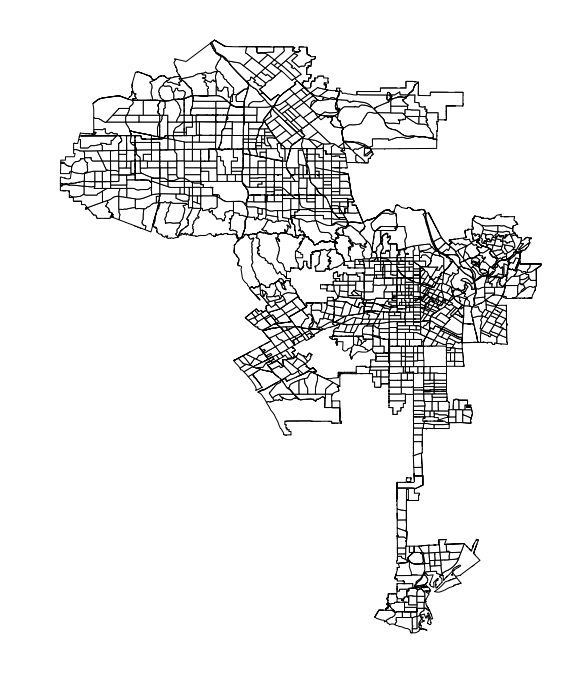

In [30]:
ax = nbd_tract.plot(color='w', edgecolor='k', figsize=(12,12))
ax.axis('off');

## Above results with Census Blocks

In [31]:
nbd_tract.crs

{'init': 'epsg:4326', 'no_defs': True}

In [32]:
block = block.to_crs(epsg = 4326)

In [33]:
block.crs

{'init': 'epsg:4326', 'no_defs': True}

In [34]:
nbd_block = spatial_overlays(nbd_tract, block)

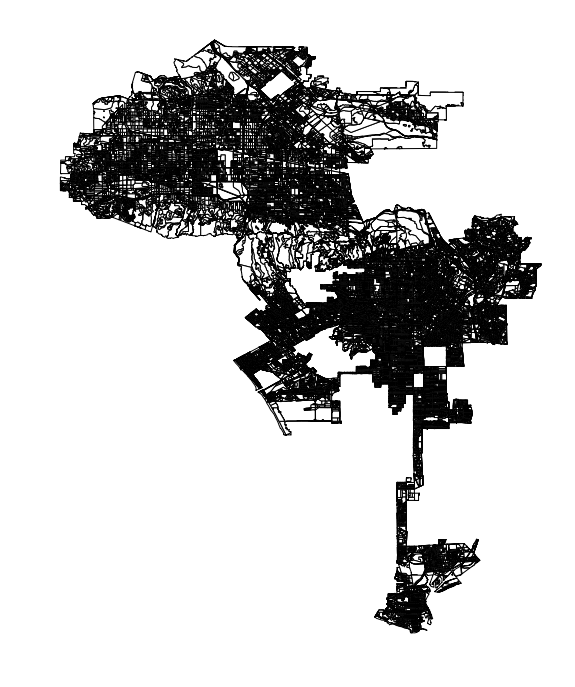

In [35]:
ax = nbd_block.plot(color='w', edgecolor='k', figsize=(12,12))
ax.axis('off');

## Trying for CDC

In [36]:
cdc = cdc.to_crs(epsg=4326)

In [37]:
cdc.crs, nbd_block.crs

({'init': 'epsg:4326', 'no_defs': True},
 {'init': 'epsg:4326', 'no_defs': True})

In [38]:
cdc.head()

,Program,Division,Type,Active,Label,Shape_STAr,Shape_STLe,geometry
0,Willowbrook Community Community Business Revit...,EHD,community business revitalization program,1,Willowbrook CRPA,1.578942e+07,17490.190856,POLYGON ((-118.2379532327456 33.92932791498923...
1,Maravilla Community Business Revitalization Area,EHD,community business revitalization program,1,Maravilla CBRA,9.146995e+06,13347.617242,POLYGON ((-118.1695150189894 34.04420325665197...
2,East Rancho Dominguez Community Business Revit...,EHD,community business revitalization program,1,East Rancho Dominguez CBRA,2.375246e+06,12758.329334,"POLYGON ((-118.198308391844 33.89555436679062,..."
3,Whiteside Community Business Revitalization Area,EHD,community business revitalization program,1,Whiteside CBRA,7.455587e+06,15640.483678,POLYGON ((-118.1780089223097 34.06229472979237...
4,City Terrace Community Business Revitalization...,EHD,community business revitalization program,1,City Terrace CBRA,7.955454e+05,6906.353498,POLYGON ((-118.1736318208955 34.05701648270423...


In [39]:
#nbd_cdc = spatial_overlays(nbd_block, cdc, how='intersection')

## The overlays fails with both inbuilt and my defined function

## Overlays by Lingyi 

#### Including 5 geometries as:
- Health Districts (HD) – 2012
- Law Enforcement Reporting Districts
- School District Boundaries (2011)
- California State Senate Districts (2011)
- US Congressional Districts

In [3]:
#Health Districts (HD) – 2012
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2012/" \
      "02/HD_20121.zip"

os.system("curl -O " + url)
os.system("unzip HD_20121.zip -d health_districts")

health_districts = gpd.read_file("health_districts" + 
                     "/Health_Districts_2012.shp")
health_districts = gpd.GeoDataFrame(health_districts)

health_districts.crs = from_epsg(2229)
health_districts = health_districts.to_crs(epsg=4326)
health_districts.head()

,OBJECTID,HD_NAME,SPA_NAME,Shape_area,Shape_len,HD_2012,SPA_2012,geometry
0,1,Alhambra,San Gabriel,1.089719e+09,2.018927e+05,3,3,"POLYGON ((-118.0942930008 34.13524499950874, -..."
1,2,Antelope Valley,Antelope Valley,3.859238e+10,1.484948e+06,5,1,POLYGON ((-117.6552358399884 34.39722196554607...
2,3,Bellflower,East,1.086595e+09,2.620187e+05,6,7,(POLYGON ((-118.0287288746297 33.8733158131870...
3,4,Central,Metro,9.044866e+08,1.811166e+05,9,4,POLYGON ((-118.2541350010089 34.11885999891331...
4,5,Compton,South,7.254541e+08,1.579749e+05,12,6,POLYGON ((-118.1429320007606 33.90246699951496...


In [4]:
#Law Enforcement Reporting Districts
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/LACOUNTY_LAW_ENFORCEMENT_RDs.zip"

os.system("curl -O " + url)
os.system("unzip LACOUNTY_LAW_ENFORCEMENT_RDs.zip -d law_enforcement")

law_enforcement = gpd.read_file("law_enforcement" + 
                     "/LACOUNTY_LAW_ENFORCEMENT_RDs.shp")
law_enforcement = gpd.GeoDataFrame(law_enforcement)

law_enforcement.crs = from_epsg(2229)
law_enforcement = law_enforcement.to_crs(epsg=4326)
law_enforcement.head()

,RD,Name,Layer,geometry
0,0230,Belvedere,Parks Bureau,POLYGON ((-118.1604325432619 34.03712079823092...
1,0231,Atlantic Avenue,Parks Bureau,"POLYGON ((-118.1550797745909 34.0257529106941,..."
2,0232,City Terrace,Parks Bureau,POLYGON ((-118.1784888821586 34.04781649689102...
3,0233,Eddie Heredia Boxing Club,Parks Bureau,POLYGON ((-118.1597359376486 34.01697488833006...
4,0234,Eugene Obregon,Parks Bureau,"POLYGON ((-118.177466480853 34.03859067464489,..."


In [5]:
#School District Boundaries (2011)
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2012/01/" \
      "rrcc_school_districts1.zip"

os.system("curl -O " + url)
os.system("unzip rrcc_school_districts1.zip -d school_districts")

school_districts = gpd.read_file("school_districts" + 
                     "/rrcc_school_districts.shp")
school_districts = gpd.GeoDataFrame(school_districts)

school_districts.crs = from_epsg(2229)
school_districts = school_districts.to_crs(epsg=4326)
school_districts.head()

,DISTRICT,UNIFIED,HIGH,ELEMENTARY,PH,ADDR,PH2,PH3,STU,HI_ADDR,HI_PH,HI_STU,LABEL,geometry
0,HERMOSA BEACH CITY ELEMENTARY,,,HERMOSA BEACH CITY ELEMENTARY,310 937 5877,1645 VALLEY DR HERMOSA BCH 90254,,,950,,,,HERMOSA BEACH CITY ELEM,POLYGON ((-118.4048577253546 33.87782346394338...
1,CENTINELA VALLEY UNION HIGH/HAWTHORNE ELEMENTARY,,CENTINELA VALLEY UNION HIGH,HAWTHORNE ELEMENTARY,310 676 2276,14120 S HAWTHORNE BL HAWTHORNE 90250,,,8145,14901 S INGLEWOOD AV LAWNDALE 90260,310 263 3200,6220,CENTINELA VALLEY UNION HIGH\nHAWTHORNE ELEMENTARY,POLYGON ((-118.3607054443706 33.93093449396304...
2,CENTINELA VALLEY UNION HIGH/LAWNDALE ELEMENTARY,,CENTINELA VALLEY UNION HIGH,LAWNDALE ELEMENTARY,310 973 1300,4161 W 147TH ST LAWNDALE 90260,,,5510,14901 S INGLEWOOD AV LAWNDALE 90260,310 263 3200,6220,CENTINELA VALLEY UNION HIGH\nLAWNDALE ELEMENTARY,"POLYGON ((-118.367294562588 33.90558198783078,..."
3,CENTINELA VALLEY UNION HIGH/LENNOX ELEMENTARY,,CENTINELA VALLEY UNION HIGH,LENNOX ELEMENTARY,310 330 4950,10319 S FIRMONA AV LENNOX 90304,,,6841,14901 S INGLEWOOD AV LAWNDALE 90260,310 263 3200,6220,CENTINELA VALLEY UNION HIGH\nLENNOX ELEMENTARY,POLYGON ((-118.3656751688557 33.95023670909119...
4,CENTINELA VALLEY UNION HIGH/WISEBURN ELEMENTARY,,CENTINELA VALLEY UNION HIGH,WISEBURN ELEMENTARY,310 643 3025,13530 AVIATION BL HAWTHORNE 90250,,,1720,14901 S INGLEWOOD AV LAWNDALE 90260,310 263 3200,6220,CENTINELA VALLEY UNION HIGH\nWISEBURN ELEMENTARY,POLYGON ((-118.3956266811697 33.93087911672388...


In [6]:
#California State Senate Districts (2011)
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2011/11/" \
      "state-senate-2011.zip"

os.system("curl -O " + url)
os.system("unzip state-senate-2011.zip -d state_senate")

state_senate = gpd.read_file("state_senate" + 
                     "/senate.shp")
state_senate = gpd.GeoDataFrame(state_senate)

state_senate.crs = from_epsg(2229)
state_senate = state_senate.to_crs(epsg=4326)
state_senate.head()

,DISTRICT,NAME,LABEL,geometry
0,16,TULKE,Disrict 16,POLYGON ((-117.6671490011134 34.75005899908675...
1,18,LASFE,Disrict 18,POLYGON ((-118.3611510010984 34.19465099908038...
2,20,POMSB,Disrict 20,POLYGON ((-117.7676900009356 34.02350599909427...
3,21,LAAVV,Disrict 21,POLYGON ((-117.6600610254095 34.49834272117203...
4,22,LACVN,Disrict 22,POLYGON ((-117.9644070011004 34.01546399908398...


In [13]:
#US Congressional Districts
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/RRCC_CONGRESSIONAL_DISTRICTS.zip"

os.system("curl -O " + url)
os.system("unzip RRCC_CONGRESSIONAL_DISTRICTS.zip -d " + 
          "congressional_districts")

congressional_districts = gpd.read_file(
                     "congressional_districts" + 
                     "/RRCC_CONGRESSIONAL_DISTRICTS.shp")
congressional_districts = gpd.GeoDataFrame(congressional_districts)

congressional_districts.crs = from_epsg(2229)
congressional_districts = congressional_districts.to_crs(epsg=4326)
congressional_districts.head()

,DIST_CONG,Shape_area,Shape_len,geometry
0,23,5.447776e+09,4.986277e+05,POLYGON ((-117.7736888188639 34.82248828448963...
1,25,4.598790e+10,1.449675e+06,(POLYGON ((-117.7668535002114 34.8232750430814...
2,26,1.535730e+08,6.420494e+04,POLYGON ((-118.7888893009787 34.16821405941698...
3,27,1.925878e+10,9.946309e+05,POLYGON ((-118.0451407369618 34.49929756618607...
4,28,6.146280e+09,6.629706e+05,POLYGON ((-118.3249597039119 34.43805010893575...


## Intersect

In [7]:
overlay_shp = spatial_overlays(health_districts, law_enforcement)
overlay_shp.shape

(6840, 11)

In [8]:
overlay_shp = spatial_overlays(overlay_shp, school_districts)
overlay_shp.shape

(8699, 24)

In [11]:
overlay_shp = spatial_overlays(overlay_shp, state_senate)
overlay_shp.shape

(10214, 27)

In [14]:
overlay_shp = spatial_overlays(overlay_shp, congressional_districts)
overlay_shp.shape

(12555, 30)

In [15]:
overlay_shp.head()

,OBJECTID,HD_NAME,SPA_NAME,Shape_area_1,Shape_len_1,HD_2012,SPA_2012,RD,Name,Layer,...,HI_PH,HI_STU,LABEL_1,DISTRICT_2,NAME,LABEL_2,DIST_CONG,Shape_area_2,Shape_len_2,geometry
0,15,Northeast,Metro,7.635810e+08,170925.611940,47,4,56,Pasadena Police,Patrol,...,,,LOS ANGELES UNIFIED SCHOOL,24,LAELA,Disrict 24,28,6.146280e+09,662970.592384,POLYGON ((-118.1807582592015 34.14156001334533...
3,15,Northeast,Metro,7.635810e+08,170925.611940,47,4,55,Pasadena Police,Patrol,...,,,LOS ANGELES UNIFIED SCHOOL,24,LAELA,Disrict 24,28,6.146280e+09,662970.592384,POLYGON ((-118.1810047618728 34.14197195877801...
6,16,Pasadena,San Gabriel,6.814773e+08,256540.374284,50,3,55,Pasadena Police,Patrol,...,,,LOS ANGELES UNIFIED SCHOOL,24,LAELA,Disrict 24,28,6.146280e+09,662970.592384,"POLYGON ((-118.180854494959 34.14164375406651,..."
9,15,Northeast,Metro,7.635810e+08,170925.611940,47,4,12,Pasadena Police,Patrol,...,,,LOS ANGELES UNIFIED SCHOOL,24,LAELA,Disrict 24,28,6.146280e+09,662970.592384,(POLYGON ((-118.1809311436235 34.1283223099131...
12,16,Pasadena,San Gabriel,6.814773e+08,256540.374284,50,3,12,Pasadena Police,Patrol,...,,,LOS ANGELES UNIFIED SCHOOL,24,LAELA,Disrict 24,28,6.146280e+09,662970.592384,POLYGON ((-118.1809311436215 34.12832230991362...


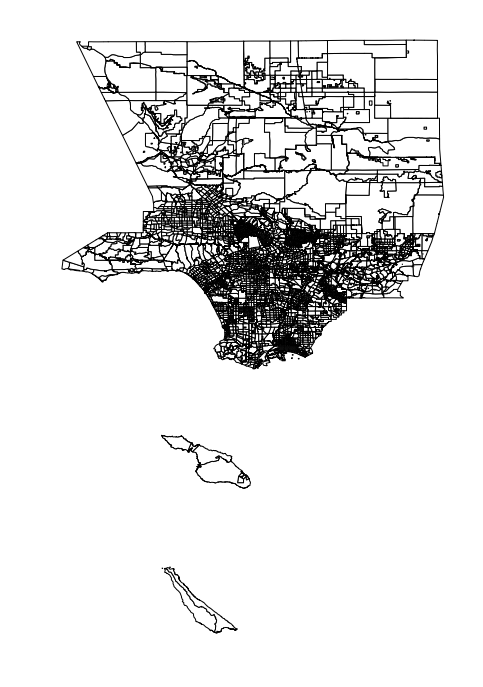

In [17]:
ax = overlay_shp.plot(color='w', edgecolor='k', figsize=(12,12))
ax.axis('off');

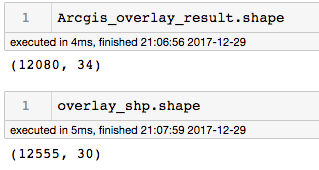

In [16]:
from IPython.display import Image
Image(filename='result_compare.png')

#### The results from Arcgis and geopandas are slightly different.